In [9]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn
import os
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

In [10]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [11]:
test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [12]:
class FoodDataset(Dataset):
    def __init__(self, tfm, path="food-11"):
        super(FoodDataset).__init__()
        self.path = path + "/valid"
        self.files = sorted([self.path + "/" + x for x in os.listdir(self.path) if x.endswith(".jpg")])

        self.transform = tfm

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)

        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1  # test has no label

        return im, label

In [13]:
from torchvision import models


class EfficientNet(nn.Module):
    def __init__(self, n_class):
        super(EfficientNet, self).__init__()
        self.efficientnet = models.efficientnet_v2_s(weights=None, progress=True)
        self.efficientnet.classifier[1] = nn.Linear(1280, n_class, bias=True)

    def forward(self, x):
        x = self.efficientnet(x)
        return x

In [14]:
_exp_name = "efficientnet_v2_s"

In [15]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
model = EfficientNet(11).to(device)
state_dict = torch.load(f"ensemble/{_exp_name}_best.ckpt")
model.load_state_dict(state_dict)
model.eval()

print(model)

EfficientNet(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchN

100%|██████████| 57/57 [00:28<00:00,  2.00it/s]


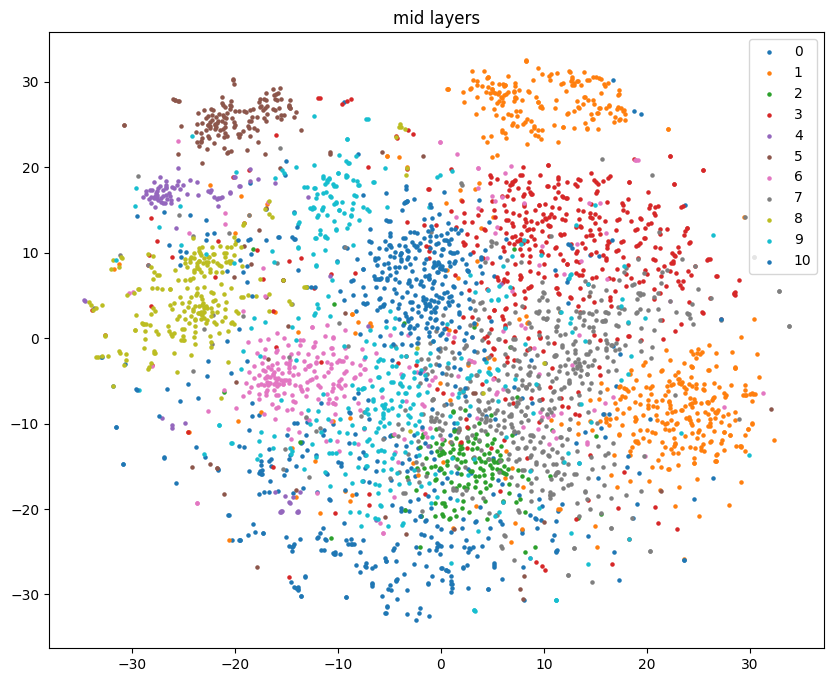

In [16]:
# Load the vaildation set defined by TA
valid_set = FoodDataset(tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
features = []
labels = []


def hook(module, input, output):
    temp.append(output.clone().detach())


handle = model.efficientnet.features[5].register_forward_hook(hook)
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    temp = []
    with torch.no_grad():
        _ = model(imgs.to(device))
        logits = temp[0].view(temp[0].size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
handle.remove()

features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init="pca", random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.title("mid layers")
plt.legend()
plt.show()


  0%|          | 0/57 [00:00<?, ?it/s]

100%|██████████| 57/57 [00:29<00:00,  1.96it/s]


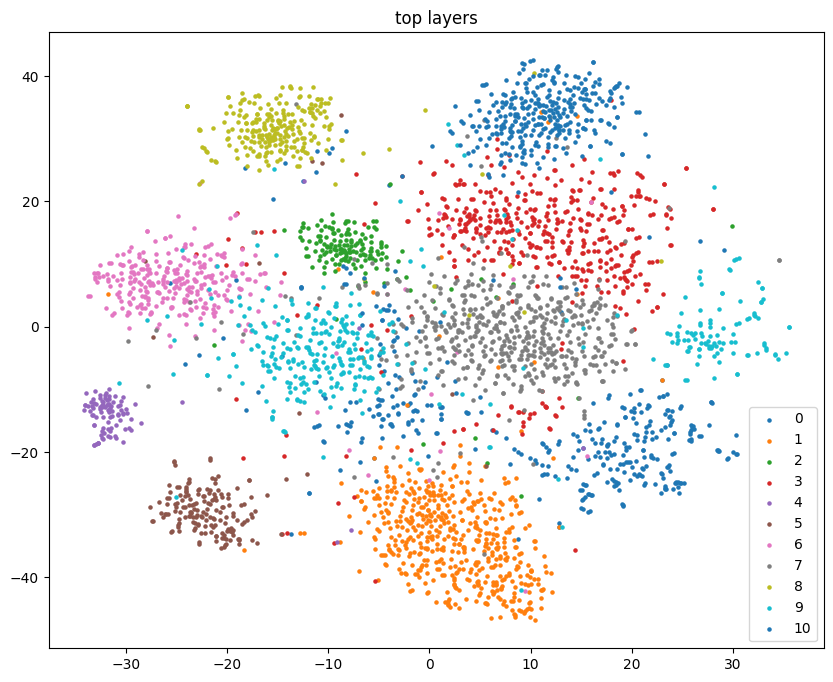

In [17]:
features = []
labels = []

handle = model.efficientnet.features[7].register_forward_hook(hook)
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    temp = []
    with torch.no_grad():
        _ = model(imgs.to(device))
        logits = temp[0].view(temp[0].size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
handle.remove()

features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init="pca", random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.title("top layers")
plt.legend()
plt.show()
